In [55]:
import pandas as pd

# Load the dataset
df = pd.read_csv('data/processed_cars_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4425 entries, 0 to 4424
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   car name         4425 non-null   object 
 1   engine_capacity  4425 non-null   float64
 2   cylinder         4425 non-null   int64  
 3   horse_power      4425 non-null   int64  
 4   top_speed        4425 non-null   int64  
 5   brand            4425 non-null   object 
 6   country          4425 non-null   object 
 7   num_seats        4425 non-null   int64  
 8   Price_USD        4425 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 311.3+ KB


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming df is your DataFrame
X = df.drop(columns=["Price_USD", "car name",'brand', 'country'])  # Drop 'Price_USD' (target) and 'car name' (irrelevant feature)
y = df["Price_USD"]

# # One-hot encode categorical features (brand, country)
# X = pd.get_dummies(X, columns=[], drop_first=True)
# X = X.astype(np.float64)

# Splitting the dataset into training (60%), validation (20%), and test (20%) sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Add bias column to scaled datasets
X_train_b = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_val_b = np.c_[np.ones((X_val_scaled.shape[0], 1)), X_val_scaled]
X_test_b = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]

X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4425 entries, 0 to 4424
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   engine_capacity  4425 non-null   float64
 1   cylinder         4425 non-null   int64  
 2   horse_power      4425 non-null   int64  
 3   top_speed        4425 non-null   int64  
 4   num_seats        4425 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 173.0 KB


# Closed-form solution & Gradient Descent With comparison between the two methods 

In [57]:
#
try:
    ##############################
    #### Run gradient descent ####
    ##############################

    theta_best_descent = np.zeros(X_train_b.shape[1])  # Includes bias term  
    # Gradient Descent Implementation
    learning_rate = 0.01
    epochs = 1000
    m = X_train_b.shape[0]  # Number of samples in training set
    
    for epoch in range(epochs):
        gradients = (1 / m) * X_train_b.T @ (X_train_b @ theta_best_descent - y_train)  # Compute gradients
        theta_best_descent -= learning_rate * gradients  # Update theta
    
    # Predictions on validation set
    y_val_pred_gd = X_val_b @ theta_best_descent
    
    # Metrics for Gradient Descent
    mse_gd = np.mean((y_val - y_val_pred_gd) ** 2)
    mae_gd = np.mean(np.abs(y_val - y_val_pred_gd))
    ss_total_gd = np.sum((y_val - np.mean(y_val)) ** 2)
    ss_residual_gd = np.sum((y_val - y_val_pred_gd) ** 2)
    r2_gd = 1 - (ss_residual_gd / ss_total_gd)
    
    # Test Set Metrics
    y_test_pred_gd = X_test_b @ theta_best_descent
    mse_gd_test = np.mean((y_test - y_test_pred_gd) ** 2)
    mae_gd_test = np.mean(np.abs(y_test - y_test_pred_gd))
    r2_gd_test = 1 - (np.sum((y_test - y_test_pred_gd) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))
    
    print(f"Gradient Descent - Validation Metrics: MSE = {mse_gd:.3f}, MAE = {mae_gd:.3f}, R² = {r2_gd:.3f}")
    print(f"Gradient Descent - Test Metrics: MSE = {mse_gd_test:.3f}, MAE = {mae_gd_test:.3f}, R² = {r2_gd_test:.3f}")
    print("Gradient Descent - Coefficients:", theta_best_descent)
    
    ##############################
    #### Closed-form solution ####
    ##############################
    theta_best_closed = np.linalg.inv(X_train_b.T @ X_train_b) @ X_train_b.T @ y_train
    y_val_pred_closed = X_val_b @ theta_best_closed
    
    # Metrics for Closed-form Solution
    mse_closed = np.mean((y_val - y_val_pred_closed) ** 2)
    mae_closed = np.mean(np.abs(y_val - y_val_pred_closed))
    ss_total_closed = np.sum((y_val - np.mean(y_val)) ** 2)
    ss_residual_closed = np.sum((y_val - y_val_pred_closed) ** 2)
    r2_closed = 1 - (ss_residual_closed / ss_total_closed)
    
    #Test Set Metrics
    y_test_pred_closed = X_test_b @ theta_best_closed
    mse_closed_test = np.mean((y_test - y_test_pred_closed) ** 2)
    mae_closed_test = np.mean(np.abs(y_test - y_test_pred_closed))
    r2_closed_test = 1 - (np.sum((y_test - y_test_pred_closed) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))
    
    print(f"\nClosed-form Solution - Validation Metrics: MSE = {mse_closed:.3f}, MAE = {mae_closed:.3f}, R² = {r2_closed:.3f}")
    print(f"Closed-form Solution - Test Metrics: MSE = {mse_closed_test:.3f}, MAE = {mae_closed_test:.3f}, R² = {r2_closed_test:.3f}")
    print("Closed-form Solution - Coefficients:", theta_best_closed)
except np.linalg.LinAlgError:
    print("Error: Singular matrix. Unable to compute the closed-form solution.")


Gradient Descent - Validation Metrics: MSE = 0.025, MAE = 0.116, R² = 0.747
Gradient Descent - Test Metrics: MSE = 0.022, MAE = 0.110, R² = 0.781
Gradient Descent - Coefficients: [-0.19666118 -0.0114911   0.05086498  0.16568283  0.10901287  0.00350892]

Closed-form Solution - Validation Metrics: MSE = 0.024, MAE = 0.115, R² = 0.751
Closed-form Solution - Test Metrics: MSE = 0.022, MAE = 0.109, R² = 0.785
Closed-form Solution - Coefficients: [-0.19666967 -0.03180407  0.05975642  0.18505718  0.09629585  0.00241054]


# LASSO and Ridge Regression with hyperparameter tuning and evaluation

LASSO - Validation Metrics: MSE= 0.024, MAE= 0.115, R²= 0.750
LASSO - Test Metrics: MSE= 0.022, MAE= 0.109, R²= 0.785
LASSO - Coefficients: [-0.0229623   0.0534617   0.18176421  0.09665524  0.00035735]

Ridge - Validation Metrics: MSE= 0.024, MAE= 0.115, R²= 0.751
Ridge - Test Metrics: MSE= 0.022, MAE= 0.109, R²= 0.785
Ridge - Coefficients: [-0.02962452  0.05907791  0.1827271   0.09707759  0.00225114]


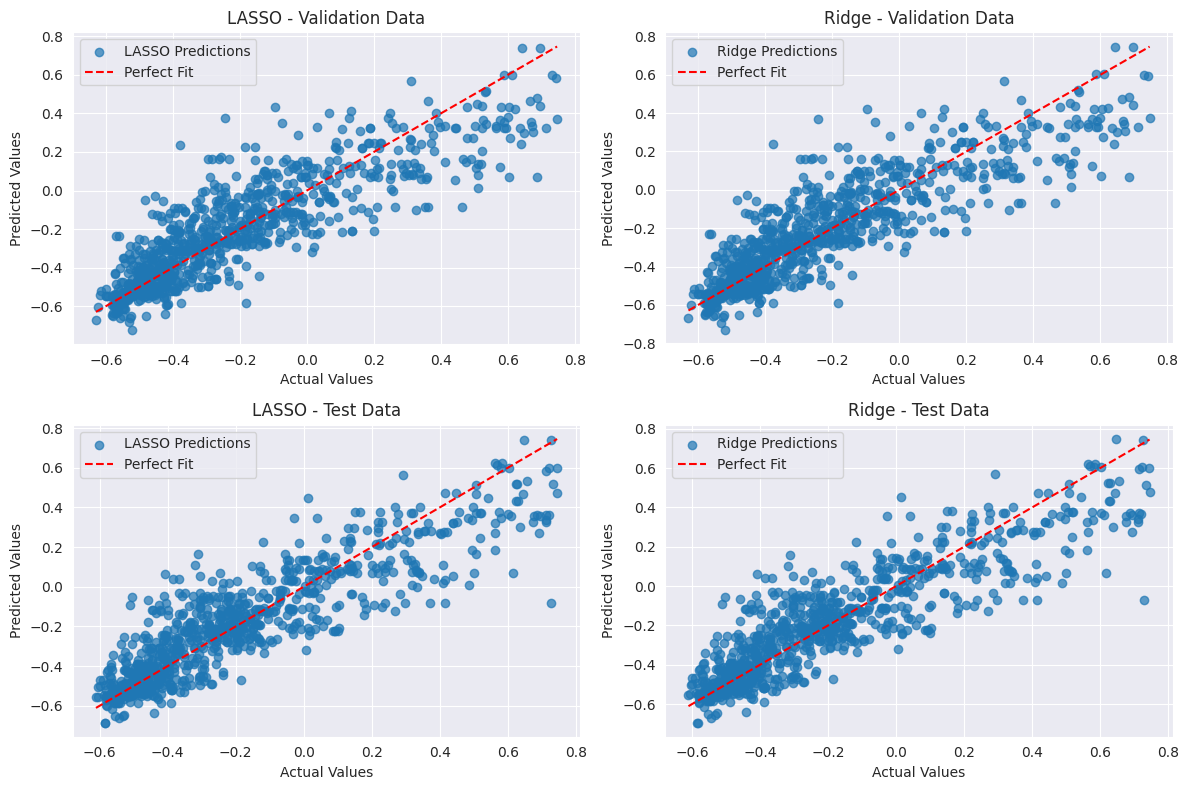

In [58]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


# Define hyperparameter grid
alpha_values = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

############################################ 
###   LASSO Regression with Grid Search  ###
############################################ 
lasso = Lasso(max_iter=10000)
lasso_grid = GridSearchCV(lasso, alpha_values, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train_scaled, y_train)
best_lasso = lasso_grid.best_estimator_

############################################ 
####  Ridge Regression with Grid Search  ###
############################################ 
ridge = Ridge()
ridge_grid = GridSearchCV(ridge, alpha_values, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train_scaled, y_train)
best_ridge = ridge_grid.best_estimator_

################################# 
###   Validation Set Metrics  ###
################################# 
# LASSO Predictions
lasso_val_pred = best_lasso.predict(X_val_scaled)
lasso_mse = mean_squared_error(y_val, lasso_val_pred)
lasso_mae = mean_absolute_error(y_val, lasso_val_pred)
lasso_r2 = r2_score(y_val, lasso_val_pred)

# Ridge Predictions
ridge_val_pred = best_ridge.predict(X_val_scaled)
ridge_mse = mean_squared_error(y_val, ridge_val_pred)
ridge_mae = mean_absolute_error(y_val, ridge_val_pred)
ridge_r2 = r2_score(y_val, ridge_val_pred)

############################# 
###  Test Set Evaluation  ###
############################# 
# LASSO Predictions
lasso_test_pred = best_lasso.predict(X_test_scaled)
lasso_test_mse = mean_squared_error(y_test, lasso_test_pred)
lasso_test_mae = mean_absolute_error(y_test, lasso_test_pred)
lasso_test_r2 = r2_score(y_test, lasso_test_pred)

# Ridge Predictions
ridge_test_pred = best_ridge.predict(X_test_scaled)
ridge_test_mse = mean_squared_error(y_test, ridge_test_pred)
ridge_test_mae = mean_absolute_error(y_test, ridge_test_pred)
ridge_test_r2 = r2_score(y_test, ridge_test_pred)

print(f"LASSO - Validation Metrics: MSE= {lasso_mse:.3f}, MAE= {lasso_mae:.3f}, R²= {lasso_r2:.3f}")
print(f"LASSO - Test Metrics: MSE= {lasso_test_mse:.3f}, MAE= {lasso_test_mae:.3f}, R²= {lasso_test_r2:.3f}")
print("LASSO - Coefficients:", best_lasso.coef_)

print(f"\nRidge - Validation Metrics: MSE= {ridge_mse:.3f}, MAE= {ridge_mae:.3f}, R²= {ridge_r2:.3f}")
print(f"Ridge - Test Metrics: MSE= {ridge_test_mse:.3f}, MAE= {ridge_test_mae:.3f}, R²= {ridge_test_r2:.3f}")
print("Ridge - Coefficients:", best_ridge.coef_)



# Scatter plots for validation data
plt.figure(figsize=(12, 8))

# LASSO on validation
plt.subplot(2, 2, 1)
plt.scatter(y_val, lasso_val_pred, alpha=0.7, label='LASSO Predictions')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('LASSO - Validation Data')
plt.legend()

# Ridge on validation
plt.subplot(2, 2, 2)
plt.scatter(y_val, ridge_val_pred, alpha=0.7, label='Ridge Predictions')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Ridge - Validation Data')
plt.legend()

# Scatter plots for test data
# LASSO on test
plt.subplot(2, 2, 3)
plt.scatter(y_test, lasso_test_pred, alpha=0.7, label='LASSO Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('LASSO - Test Data')
plt.legend()

# Ridge on test
plt.subplot(2, 2, 4)
plt.scatter(y_test, ridge_test_pred, alpha=0.7, label='Ridge Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Ridge - Test Data')
plt.legend()

plt.tight_layout()
plt.show()


# Polynomial Regression and Radial Basis Function (RBF) Kernel Regression

Polynomial Regression Results:
Degree 2 - validation : MSE = 0.022, MAE = 0.107, R² = 0.771
Degree 2 - test : MSE = 0.020, MAE = 0.102, R² = 0.807


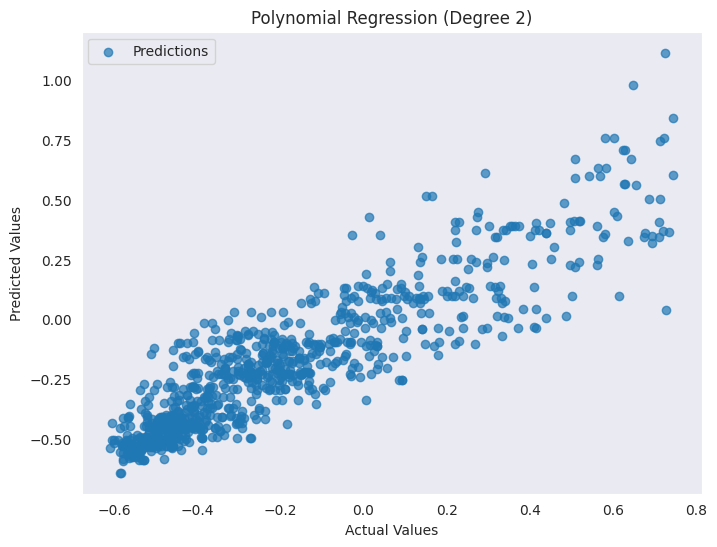

Degree 3 - validation : MSE = 0.020, MAE = 0.103, R² = 0.791
Degree 3 - test : MSE = 0.028, MAE = 0.103, R² = 0.728


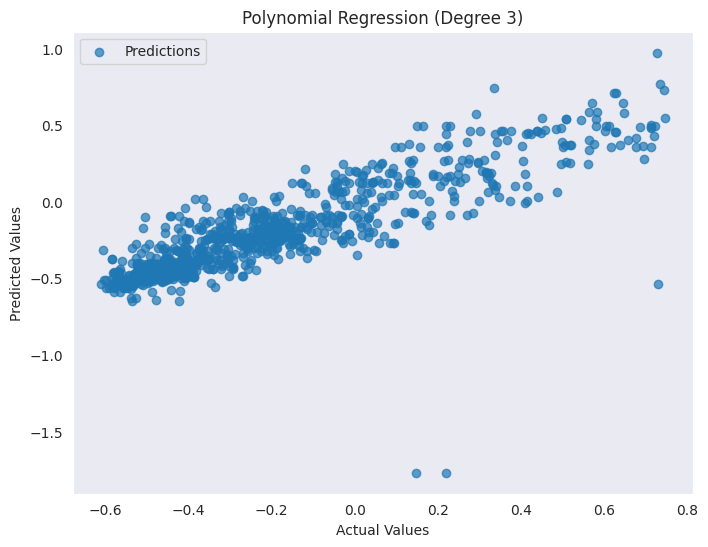

Degree 4 - validation : MSE = 0.024, MAE = 0.099, R² = 0.752
Degree 4 - test : MSE = 0.019, MAE = 0.095, R² = 0.818


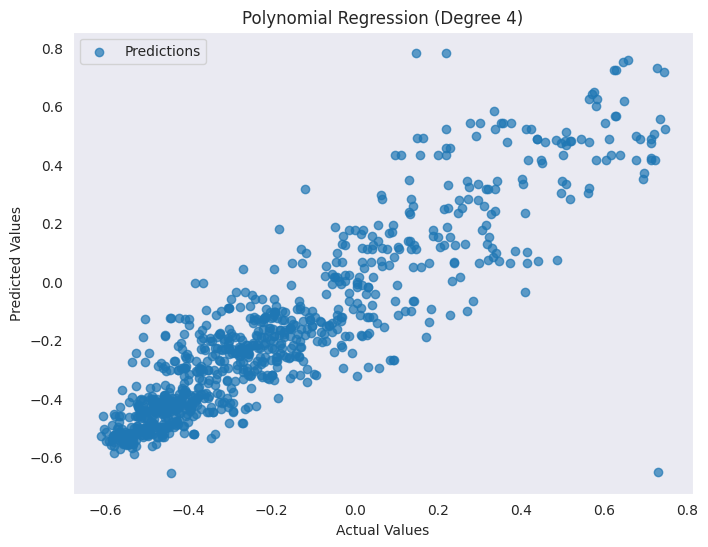

Degree 5 - validation : MSE = 0.234, MAE = 0.125, R² = -1.399
Degree 5 - test : MSE = 0.524, MAE = 0.134, R² = -4.100


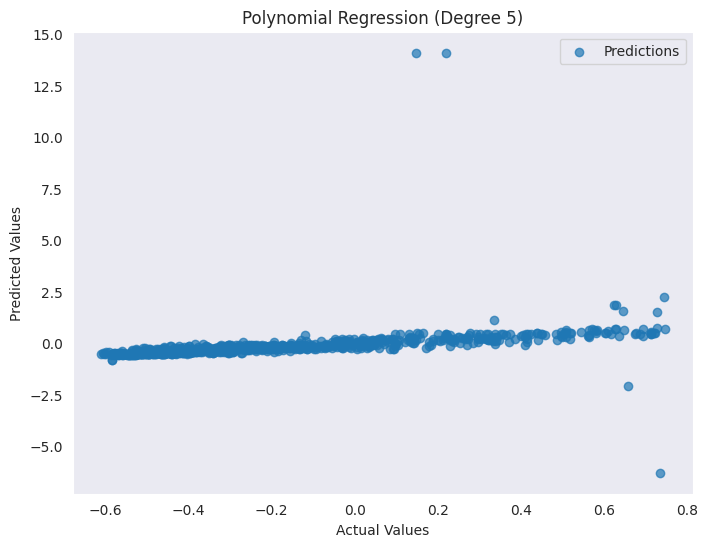

Degree 6 - validation : MSE = 16134.256, MAE = 7.080, R² = -165772.874
Degree 6 - test : MSE = 6156.370, MAE = 4.465, R² = -59894.787


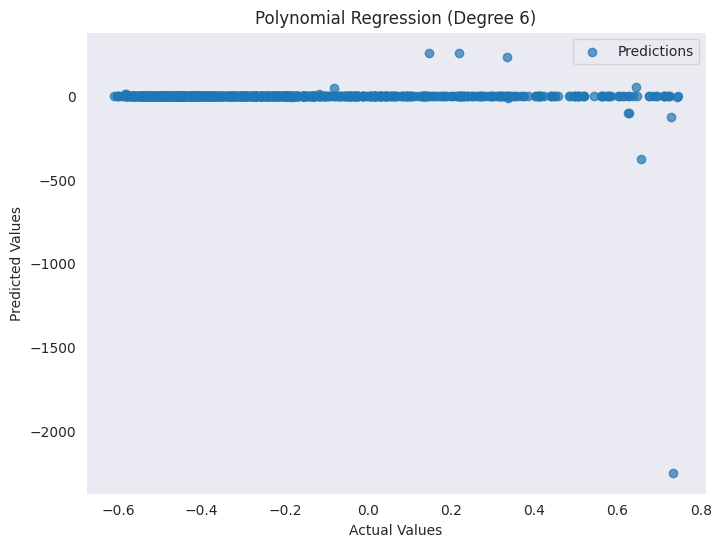

Degree 7 - validation : MSE = 17657607044.709, MAE = 9219.955, R² = -181425777883.154
Degree 7 - test : MSE = 56750383157.687, MAE = 16676.930, R² = -552128757481.663


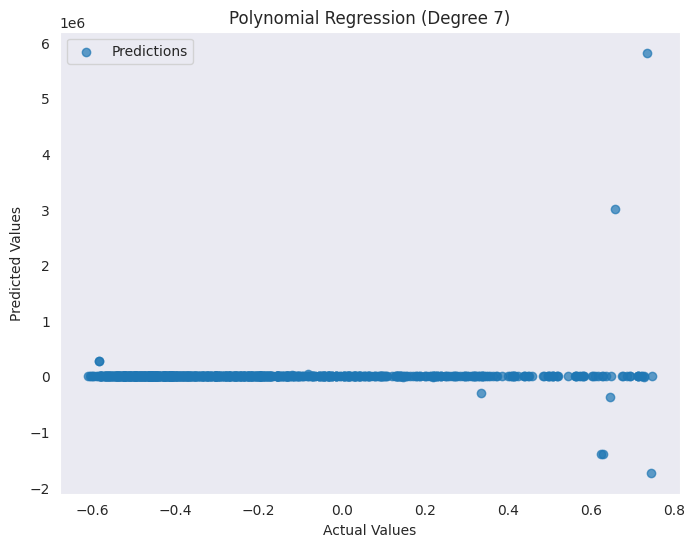

Degree 8 - validation : MSE = 3530094781.788, MAE = 5322.729, R² = -36270497477.457
Degree 8 - test : MSE = 44872489048.388, MAE = 11988.512, R² = -436567829939.453


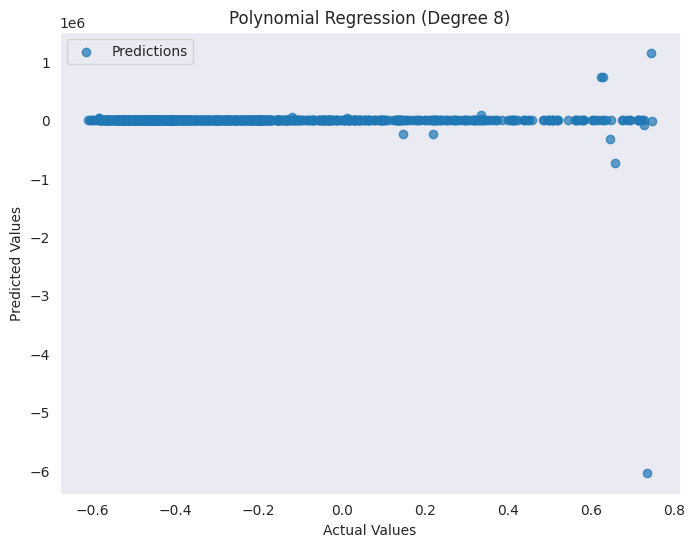

Degree 9 - validation : MSE = 377569553079.433, MAE = 53793.908, R² = -3879395984934.291
Degree 9 - test : MSE = 261447708404.661, MAE = 25229.211, R² = -2543644471738.606


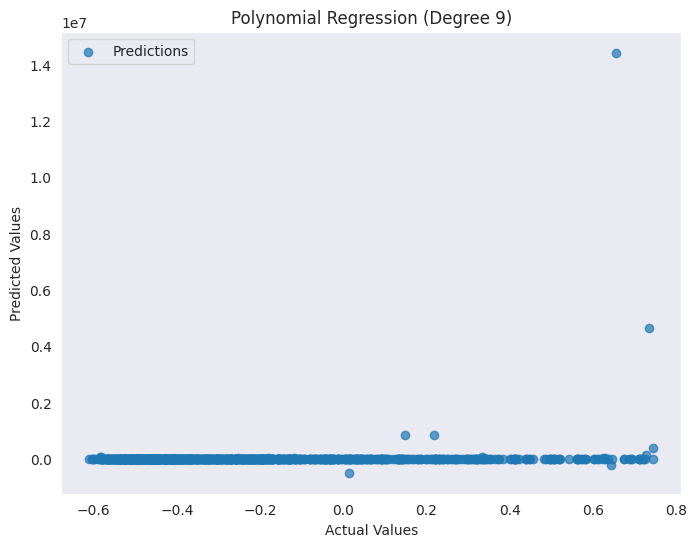

Degree 10 - validation : MSE = 13007704204662.213, MAE = 275716.318, R² = -133649641644107.625
Degree 10 - test : MSE = 6900379140889.531, MAE = 163302.630, R² = -67134309043030.773


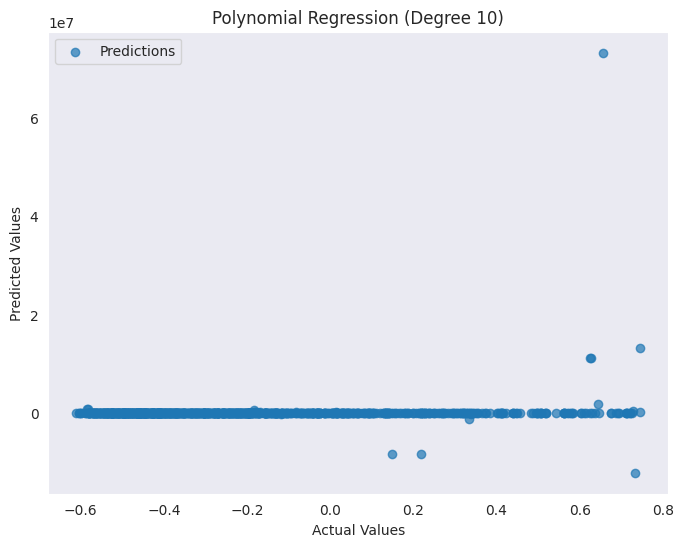


RBF Kernel Regression Results:
Best RBF MSE on Validation Set: 0.019, MAE = 0.093, R² = 0.800
Best RBF MSE on Test Set: 0.015, MAE = 0.089, R² = 0.853
Best RBF Model Hyperparameters: {'C': 10, 'gamma': 1}


In [59]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

#######################################
###  Polynomial Regression Results  ###
#######################################
print("Polynomial Regression Results:")
for degree in range(2, 11): # Degrees from 2 to 10 inclusive
    # Transform input features to polynomial features
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_val_poly = poly.transform(X_val_scaled)
    X_test_poly = poly.transform(X_test_scaled)
    # Train Linear Regression model
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_poly, y_train)
    
    # Calculate evaluation metrics for validation set
    y_val_pred_poly = lin_reg.predict(X_val_poly)
    mse_poly = mean_squared_error(y_val, y_val_pred_poly)
    mae_poly = mean_absolute_error(y_val, y_val_pred_poly)
    r2_poly = r2_score(y_val, y_val_pred_poly)
     
    # calculate evaluation metrics for test set 
    y_test_pred_poly = lin_reg.predict(X_test_poly)
    mse_poly_test = mean_squared_error(y_test, y_test_pred_poly)
    mae_poly_test = mean_absolute_error(y_test, y_test_pred_poly)
    r2_poly_test = r2_score(y_test, y_test_pred_poly)
    print(f"Degree {degree} - validation : MSE = {mse_poly:.3f}, MAE = {mae_poly:.3f}, R² = {r2_poly:.3f}")
    print(f"Degree {degree} - test : MSE = {mse_poly_test:.3f}, MAE = {mae_poly_test:.3f}, R² = {r2_poly_test:.3f}")
    
    # Plotting the predictions vs actual values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_test_pred_poly, alpha=0.7, label="Predictions")
    plt.title(f"Polynomial Regression (Degree {degree})")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.grid()
    plt.show()
    

#######################################################
###  Radial Basis Function (RBF) Kernel Regression  ###
#######################################################
print("\nRBF Kernel Regression Results:")

# Define hyperparameter grid for SVR
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10]}
rbf_svr = SVR(kernel='rbf')

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(rbf_svr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Best RBF model from grid search
best_rbf_model = grid_search.best_estimator_

# Predictions on validation set
y_val_pred_rbf = best_rbf_model.predict(X_val_scaled)


y_val_pred_rbf_test = best_rbf_model.predict(X_test_scaled)

# Calculate evaluation metrics for RBF
mse_rbf = mean_squared_error(y_val, y_val_pred_rbf)
mae_rbf = mean_absolute_error(y_val, y_val_pred_rbf)
r2_rbf = r2_score(y_val, y_val_pred_rbf)

mse_rbf_test = mean_squared_error(y_test ,y_val_pred_rbf_test)
mae_rbf_test = mean_absolute_error(y_test, y_val_pred_rbf_test)
r2_rbf_test = r2_score(y_test, y_val_pred_rbf_test)

print(f"Best RBF MSE on Validation Set: {mse_rbf:.3f}, MAE = {mae_rbf:.3f}, R² = {r2_rbf:.3f}")
print(f"Best RBF MSE on Test Set: {mse_rbf_test:.3f}, MAE = {mae_rbf_test:.3f}, R² = {r2_rbf_test:.3f}")
print("Best RBF Model Hyperparameters:", grid_search.best_params_)



# Feature Selection with Forward Selection

In [60]:
n_features = X_train_scaled.shape[1]
selected_features = []
remaining_features = list(range(n_features))
best_r2 = -float("inf")  # Start with the lowest possible R-squared
max_features = 4  # Maximum number of features to select

while remaining_features and len(selected_features) < max_features:
    best_feature = None
    for feature in remaining_features:
        # Evaluate feature
        candidate_features = selected_features + [feature]
        model = LinearRegression()
        model.fit(X_train_scaled[:, candidate_features], y_train)
        y_val_pred = model.predict(X_val_scaled[:, candidate_features])
        r2 = r2_score(y_val, y_val_pred)

        # Check if this feature is the best so far
        if r2 > best_r2:
            best_r2 = r2
            best_feature = feature

    # Stop if no improvement
    if best_feature is None:
        break

    # Add the best feature
    selected_features.append(best_feature)
    remaining_features.remove(best_feature)
    print(f"Selected Feature: {best_feature}, Validation R^2: {best_r2}")

# Train final model with selected features
final_model = LinearRegression()
final_model.fit(X_train_scaled[:, selected_features], y_train)

# Print the selected features
print("Selected Features:", selected_features)

# Evaluate on the test set
y_test_pred = final_model.predict(X_test_scaled[:, selected_features])
r2_test = r2_score(y_test, y_test_pred)
print("Test R^2 with Selected Features:", r2_test)
  

Selected Feature: 2, Validation R^2: 0.6968645803452354
Selected Feature: 3, Validation R^2: 0.7372993829824512
Selected Feature: 1, Validation R^2: 0.7445911304177518
Selected Feature: 0, Validation R^2: 0.7508973847152126
Selected Features: [2, 3, 1, 0]
Test R^2 with Selected Features: 0.785512910519958
